In [2]:
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px


In [3]:
match_summary = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\dim_match_summary.csv")
players = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\dim_players.csv")
bating_summary = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\fact_bating_summary.csv")
bowling_summary = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\fact_bowling_summary.csv")


In [4]:
### Top 10 batsmen based on past 3 years total runs scored

# Merge the two DataFrames on a common column (e.g., 'match_id')
merged_df = pd.merge(match_summary, bating_summary, on='match_id', how='inner')  # Change 'inner' to 'left', 'right', or 'outer' depending on the merge type

# Display the merged DataFrame
print(merged_df)




# Convert matchDate to datetime
merged_df['matchDate'] = pd.to_datetime(merged_df['matchDate'], errors='coerce')

# Filter data for the last 3 years
three_years_ago = pd.Timestamp.now() - pd.DateOffset(years=3)
recent_df = merged_df[merged_df['matchDate'] >= three_years_ago]

# Group by batsmanName and sum total runs
batsman_runs = recent_df.groupby('batsmanName')['runs'].sum()

# Sort and get top 10 batsmen
top_10_batsmen_3Years = batsman_runs.sort_values(ascending=False).head(10)

# Display the result
print(top_10_batsmen_3Years)



top_10_df = top_10_batsmen_3Years.reset_index()
top_10_df.columns = ['Batsman', 'Total Runs']

# Create the bar chart
fig = px.bar(
    top_10_df,
    x='Batsman',
    y='Total Runs',
    title='Top 10 Batsmen by Total Runs (Past 3 Years)',
    text='Total Runs',
    color='Total Runs',
    color_continuous_scale='Viridis'
)

# Add hover and styling
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    xaxis_title='Batsman',
    yaxis_title='Total Runs',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(showgrid=False),
)

# Show the figure
fig.show()



# Convert date and extract year
merged_df['matchDate'] = pd.to_datetime(merged_df['matchDate'], errors='coerce')
merged_df['year'] = merged_df['matchDate'].dt.year

# Filter for the last 3 years
three_years = sorted(merged_df['year'].dropna().unique())[-3:]
recent_df = merged_df[merged_df['year'].isin(three_years)]

# Step 1: Group by batsman and year to check balls faced each year
balls_per_year = recent_df.groupby(['batsmanName', 'year'])['balls'].sum().reset_index()

# Step 2: Keep batsmen who have faced at least 60 balls in each of the 3 years
qualified_batsmen = (
    balls_per_year[balls_per_year['balls'] >= 60]
    .groupby('batsmanName')['year']
    .nunique()
)
qualified_batsmen = qualified_batsmen[qualified_batsmen == 3].index.tolist()

# Step 3: Filter original data for these qualified batsmen
qualified_df = recent_df[recent_df['batsmanName'].isin(qualified_batsmen)]

# Step 4: Calculate total runs and outs
qualified_df['is_out'] = qualified_df['out/not_out'].apply(lambda x: 1 if x == 'out' else 0)

batting_stats = qualified_df.groupby('batsmanName').agg({
    'runs': 'sum',
    'is_out': 'sum'
}).reset_index()

# Step 5: Calculate batting average
batting_stats = batting_stats[batting_stats['is_out'] > 0]
batting_stats['batting_average'] = batting_stats['runs'] / batting_stats['is_out']

# Step 6: Sort and get top 10
top_10_avg = batting_stats.sort_values(by='batting_average', ascending=False).head(10)

print(top_10_avg[['batsmanName', 'batting_average']])



# Prepare the DataFrame (if not already done)
top_10_avg_df = top_10_avg[['batsmanName', 'batting_average']].copy()
top_10_avg_df.columns = ['Batsman', 'Batting Average']

# Create the interactive bar chart
fig = px.bar(
    top_10_avg_df,
    x='Batsman',
    y='Batting Average',
    text='Batting Average',
    title='Top 10 Batsmen by Batting Average (Past 3 Years, Min 60 Balls/Season)',
    color='Batting Average',
    color_continuous_scale='Plasma'
)

# Style it
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Batsman',
    yaxis_title='Batting Average',
    yaxis=dict(showgrid=False),
    plot_bgcolor='rgba(0,0,0,0)',
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

# Show the plot
fig.show()


### Top 10 batsmen based on past 3 years strike rate (min 60 balls faced in each season)

# Step 1: Convert date and extract year
merged_df['matchDate'] = pd.to_datetime(merged_df['matchDate'], errors='coerce')
merged_df['year'] = merged_df['matchDate'].dt.year

# Step 2: Filter for the last 3 years
three_years = sorted(merged_df['year'].dropna().unique())[-3:]
recent_df = merged_df[merged_df['year'].isin(three_years)]

# Step 3: Group by batsman and year, sum balls faced
balls_per_year = recent_df.groupby(['batsmanName', 'year'])['balls'].sum().reset_index()

# Step 4: Keep batsmen who faced >=60 balls in each of the 3 years
qualified_batsmen = (
    balls_per_year[balls_per_year['balls'] >= 60]
    .groupby('batsmanName')['year']
    .nunique()
)
qualified_batsmen = qualified_batsmen[qualified_batsmen == 3].index.tolist()

# Step 5: Filter recent data for qualified batsmen
qualified_df = recent_df[recent_df['batsmanName'].isin(qualified_batsmen)]

# Step 6: Calculate total runs and balls for those players
strike_rate_stats = qualified_df.groupby('batsmanName').agg({
    'runs': 'sum',
    'balls': 'sum'
}).reset_index()

# Step 7: Calculate strike rate
strike_rate_stats = strike_rate_stats[strike_rate_stats['balls'] > 0]
strike_rate_stats['strike_rate'] = (strike_rate_stats['runs'] / strike_rate_stats['balls']) * 100

# Step 8: Get Top 10 by strike rate
top_10_sr = strike_rate_stats.sort_values(by='strike_rate', ascending=False).head(10)
print(top_10_sr[['batsmanName', 'strike_rate']])


top_10_sr_df = top_10_sr[['batsmanName', 'strike_rate']].copy()
top_10_sr_df.columns = ['Batsman', 'Strike Rate']

# Create interactive bar chart
fig = px.bar(
    top_10_sr_df,
    x='Batsman',
    y='Strike Rate',
    text='Strike Rate',
    title='Top 10 Batsmen by Strike Rate (Past 3 Years, Min 60 Balls/Season)',
    color='Strike Rate',
    color_continuous_scale='Viridis'
)

# Style the chart
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Batsman',
    yaxis_title='Strike Rate',
    yaxis=dict(showgrid=False),
    plot_bgcolor='rgba(0,0,0,0)',
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()


            team1   team2       winner     margin     matchDate match_id  \
0     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
1     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
2     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
3     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
4     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
...           ...     ...          ...        ...           ...      ...   
3263  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
3264  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
3265  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
3266  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
3267  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   

                      match  teamInnings  battingPos     batsmanName  \
0        Super 

        batsmanName  batting_average
14          KLRahul        50.533333
9      FafduPlessis        43.595238
4       DavidMiller        43.200000
13       JosButtler        41.916667
32   ShimronHetmyer        40.666667
34      ShubmanGill        40.266667
31    ShikharDhawan        39.771429
29   RuturajGaikwad        38.219512
5       DavidWarner        37.900000
35  SuryakumarYadav        35.000000


C:\Users\saich\AppData\Local\Temp\ipykernel_1188\2656157959.py:83: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



        batsmanName  strike_rate
10     GlennMaxwell   161.436170
35  SuryakumarYadav   160.550459
3      AndreRussell   159.188034
32   ShimronHetmyer   157.274401
21   NicholasPooran   157.112069
23      PrithviShaw   153.195489
8     DineshKarthik   152.643172
39  YashasviJaiswal   152.150538
13       JosButtler   146.932814
33       ShivamDube   145.732689


In [5]:
### Top 10 bowlers based on past 3 years total wickets taken.


# Merge the two DataFrames on a common column (e.g., 'match_id')
merged_df_Bowling = pd.merge(match_summary, bowling_summary, on='match_id', how='inner')  # Change 'inner' to 'left', 'right', or 'outer' depending on the merge type

# Display the merged DataFrame
print(merged_df_Bowling)



# Step 1: Convert matchDate and extract year
merged_df_Bowling['matchDate'] = pd.to_datetime(merged_df_Bowling['matchDate'], errors='coerce')
merged_df_Bowling['year'] = merged_df_Bowling['matchDate'].dt.year

# Step 2: Filter for the last 3 years
last_3_years = sorted(merged_df_Bowling['year'].dropna().unique())[-3:]
recent_bowling_df = merged_df_Bowling[merged_df_Bowling['year'].isin(last_3_years)]

# Step 3: Group by bowlerName and sum the wickets
top_wicket_takers = (
    recent_bowling_df.groupby('bowlerName')['wickets']
    .sum()
    .reset_index()
    .sort_values(by='wickets', ascending=False)
    .head(10)
)

print(top_wicket_takers)




fig = px.bar(
    top_wicket_takers,
    x='bowlerName',
    y='wickets',
    title='Top 10 Bowlers by Wickets Taken (Past 3 Years)',
    text='wickets',
    color='wickets',
    color_continuous_scale='Cividis'
)

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    xaxis_title='Bowler',
    yaxis_title='Total Wickets',
    yaxis=dict(showgrid=False),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

### Top 10 bowlers based on past 3 years bowling average. (min 60 balls bowled in each season


# Step 1: Ensure matchDate is datetime and extract year
merged_df_Bowling['matchDate'] = pd.to_datetime(merged_df_Bowling['matchDate'], errors='coerce')
merged_df_Bowling['year'] = merged_df_Bowling['matchDate'].dt.year

# Step 2: Filter for last 3 years
last_3_years = sorted(merged_df_Bowling['year'].dropna().unique())[-3:]
df_recent = merged_df_Bowling[merged_df_Bowling['year'].isin(last_3_years)].copy()

# Step 3: Convert overs to balls (account for decimal overs)
def overs_to_balls(overs):
    whole = int(overs)
    fraction = overs - whole
    balls = whole * 6 + round(fraction * 10)
    return balls

df_recent['balls'] = df_recent['overs'].apply(overs_to_balls)

# Step 4: Group by bowler and year to filter those with at least 60 balls each season
season_balls = df_recent.groupby(['bowlerName', 'year'])['balls'].sum().reset_index()
eligible_bowlers = (
    season_balls[season_balls['balls'] >= 60]
    .groupby('bowlerName')['year']
    .nunique()
    .reset_index()
)
eligible_bowlers = eligible_bowlers[eligible_bowlers['year'] == 3]['bowlerName']

# Step 5: Filter main data to only include eligible bowlers
eligible_df = df_recent[df_recent['bowlerName'].isin(eligible_bowlers)]

# Step 6: Calculate total runs, wickets, and bowling average
bowler_stats = (
    eligible_df.groupby('bowlerName')
    .agg({'runs': 'sum', 'wickets': 'sum'})
    .reset_index()
)
bowler_stats = bowler_stats[bowler_stats['wickets'] > 0].copy()
bowler_stats['bowling_average'] = bowler_stats['runs'] / bowler_stats['wickets']

# Step 7: Get Top 10 bowlers with best (lowest) average
top_10_avg = bowler_stats.sort_values(by='bowling_average').head(10)
print(top_10_avg[['bowlerName', 'bowling_average']])


top_10_avg_df = top_10_avg[['bowlerName', 'bowling_average']].copy()
top_10_avg_df.columns = ['Bowler', 'Bowling Average']

# Create the interactive bar chart
fig = px.bar(
    top_10_avg_df,
    x='Bowler',
    y='Bowling Average',
    text='Bowling Average',
    title='Top 10 Bowlers by Bowling Average (Past 3 Years, Min 60 Balls Bowled per Season)',
    color='Bowling Average',
    color_continuous_scale='Cividis'
)

# Style the chart
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Bowler',
    yaxis_title='Bowling Average',
    yaxis=dict(showgrid=False),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

### Top 10 bowlers based on past 3 years economy rate. (min 60 balls bowled in each season)


# Step 1: Ensure matchDate is datetime and extract year
merged_df_Bowling['matchDate'] = pd.to_datetime(merged_df_Bowling['matchDate'], errors='coerce')
merged_df_Bowling['year'] = merged_df_Bowling['matchDate'].dt.year

# Step 2: Filter for last 3 years
last_3_years = sorted(merged_df_Bowling['year'].dropna().unique())[-3:]
df_recent = merged_df_Bowling[merged_df_Bowling['year'].isin(last_3_years)].copy()

# Step 3: Convert overs to balls (account for decimal overs)
def overs_to_balls(overs):
    whole = int(overs)
    fraction = overs - whole
    balls = whole * 6 + round(fraction * 10)
    return balls

df_recent['balls'] = df_recent['overs'].apply(overs_to_balls)

# Step 4: Group by bowler and year to filter those with at least 60 balls each season
season_balls = df_recent.groupby(['bowlerName', 'year'])['balls'].sum().reset_index()
eligible_bowlers = (
    season_balls[season_balls['balls'] >= 60]
    .groupby('bowlerName')['year']
    .nunique()
    .reset_index()
)
eligible_bowlers = eligible_bowlers[eligible_bowlers['year'] == 3]['bowlerName']

# Step 5: Filter main data to only include eligible bowlers
eligible_df = df_recent[df_recent['bowlerName'].isin(eligible_bowlers)]

# Step 6: Calculate total runs, balls, and economy rate
bowler_stats = (
    eligible_df.groupby('bowlerName')
    .agg({'runs': 'sum', 'balls': 'sum'})
    .reset_index()
)
bowler_stats = bowler_stats[bowler_stats['balls'] > 0].copy()
bowler_stats['economy_rate'] = (bowler_stats['runs'] / bowler_stats['balls']) * 6

# Step 7: Get Top 10 bowlers with best (lowest) economy rate
top_10_economy = bowler_stats.sort_values(by='economy_rate').head(10)
print(top_10_economy[['bowlerName', 'economy_rate']])




# Prepare the data for visualization
top_10_economy_df = top_10_economy[['bowlerName', 'economy_rate']].copy()
top_10_economy_df.columns = ['Bowler', 'Economy Rate']

# Create the interactive bar chart
fig = px.bar(
    top_10_economy_df,
    x='Bowler',
    y='Economy Rate',
    text='Economy Rate',
    title='Top 10 Bowlers by Economy Rate (Past 3 Years, Min 60 Balls Bowled per Season)',
    color='Economy Rate',
    color_continuous_scale='Viridis'
)

# Style the chart
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Bowler',
    yaxis_title='Economy Rate',
    yaxis=dict(showgrid=False),
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()



            team1   team2       winner     margin     matchDate match_id  \
0     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
1     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
2     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
3     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
4     Super Kings     KKR  Super Kings    27 runs  Oct 15, 2021  T203817   
...           ...     ...          ...        ...           ...      ...   
2431  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
2432  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
2433  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
2434  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   
2435  Super Kings  Titans       Titans  5 wickets  Mar 31, 2023  T201566   

                      match  bowlingTeam             bowlerName  overs  \
0        Supe

         bowlerName  bowling_average
0      AndreRussell        18.228571
31  YuzvendraChahal        20.196970
19       RashidKhan        20.206349
9      HarshalPatel        20.353846
16    MohammedShami        20.537313
3         AveshKhan        23.723404
11     KagisoRabada        23.755556
15         MoeenAli        23.857143
1      AnrichNortje        24.774194
28       UmranMalik        26.103448


            bowlerName  economy_rate
26         SunilNarine      6.600000
15            MoeenAli      7.039813
19          RashidKhan      7.078777
4            AxarPatel      7.113636
22      RavindraJadeja      7.393939
13        KrunalPandya      7.449190
21  RavichandranAshwin      7.500000
29   VarunChakravarthy      7.572025
8         HarpreetBrar      7.602015
18         RahulChahar      7.629187


In [6]:
### Top 5 batsmen based on past 3 years boundary % (fours and sixes)



# Check for rows with invalid date formats and manually fix them
merged_df['matchDate'] = pd.to_datetime(merged_df['matchDate'], errors='coerce')

# Check for rows that are still invalid after conversion
invalid_dates = merged_df[merged_df['matchDate'].isna()]

# Optionally, print these invalid dates to understand the issue
print(invalid_dates)

# You can either drop rows with invalid dates or fix them manually
# merged_df = merged_df.dropna(subset=['matchDate'])

# Now proceed with the filtering for the past 3 years
three_years_ago = pd.to_datetime('today') - pd.DateOffset(years=3)
df_recent = merged_df[merged_df['matchDate'] >= three_years_ago]

# Continue with the boundary percentage calculation
df_recent['total_boundaries'] = df_recent['4s'] + df_recent['6s']
df_recent['boundary_percentage'] = (df_recent['total_boundaries'] / df_recent['balls']) * 100

# Group by batsman and calculate the total boundaries and balls faced
batsman_stats = (
    df_recent.groupby('batsmanName')
    .agg({'total_boundaries': 'sum', 'balls': 'sum'})
    .reset_index()
)

# Calculate boundary percentage for each batsman
batsman_stats['boundary_percentage'] = (batsman_stats['total_boundaries'] / batsman_stats['balls']) * 100

# Sort by boundary percentage in descending order and get the top 5 batsmen
top_batsmen = batsman_stats.sort_values('boundary_percentage', ascending=False).head(5)

# Display the result
print(top_batsmen[['batsmanName', 'boundary_percentage']])



# Create the bar plot for the top 5 batsmen based on boundary percentage
fig = px.bar(top_batsmen, 
             x='batsmanName', 
             y='boundary_percentage', 
             title='Top 5 Batsmen Based on Boundary Percentage (Fours and Sixes)',
             labels={'batsmanName': 'Batsman', 'boundary_percentage': 'Boundary Percentage'},
             color='boundary_percentage', 
             color_continuous_scale='Blues')

# Show the plot
fig.show()



# Assuming merged_df_Bowling is already loaded with the required columns

# Step 1: Convert overs to balls
# If 'overs' is a string in format like '3.2', convert to balls (3 overs and 2 balls)
merged_df_Bowling['balls'] = merged_df_Bowling['overs'].apply(lambda x: int(str(x).split('.')[0]) * 6 + int(str(x).split('.')[1]) if '.' in str(x) else int(str(x)) * 6)

# Step 2: Calculate dot ball percentage
merged_df_Bowling['dot_ball_percentage'] = (merged_df_Bowling['0s'] / merged_df_Bowling['balls']) * 100

# Step 3: Group by bowler and sum dot balls and total balls
bowler_stats = merged_df_Bowling.groupby('bowlerName').agg(
    total_dot_balls=('0s', 'sum'),
    total_balls_bowled=('balls', 'sum')
).reset_index()

# Step 4: Calculate dot ball percentage for each bowler
bowler_stats['dot_ball_percentage'] = (bowler_stats['total_dot_balls'] / bowler_stats['total_balls_bowled']) * 100

# Step 5: Sort bowlers by dot ball percentage in descending order and get top 5
top_bowlers_dot_percentage = bowler_stats.sort_values(by='dot_ball_percentage', ascending=False).head(5)

# Visualize the top 5 bowlers based on dot ball percentage

fig = px.bar(top_bowlers_dot_percentage, x='bowlerName', y='dot_ball_percentage',
             title="Top 5 Bowlers Based on Dot Ball Percentage (Past 3 Years)",
             labels={'dot_ball_percentage': 'Dot Ball Percentage', 'bowlerName': 'Bowler'},
             color='dot_ball_percentage', color_continuous_scale='Blues')

fig.show()






       team1        team2       winner     margin matchDate match_id  \
2095  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2096  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2097  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2098  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2099  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2100  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2101  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2102  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2103  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2104  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2105  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   
2106  Titans  Super Kings  Super Kings  5 wickets       NaT  T208201   

                      match  teamInnings  battingPos     batsma

C:\Users\saich\AppData\Local\Temp\ipykernel_1188\1387397501.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\saich\AppData\Local\Temp\ipykernel_1188\1387397501.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
### Top 4 teams based on past 3 years winning %



match_summary['matchDate'] = pd.to_datetime(match_summary['matchDate'], errors='coerce')

# Filter for past 3 years
three_years_ago = pd.to_datetime('today') - pd.DateOffset(years=3)
df_recent = match_summary[match_summary['matchDate'] >= three_years_ago].copy()

# Step 1: Count total matches played per team
# Stack team1 and team2 to count matches each team played
matches_played = (
    df_recent[['team1', 'team2']]
    .melt(value_name='team')[['team']]
    .value_counts()
    .rename_axis('team')
    .reset_index(name='matches_played')
)

# Step 2: Count total wins per team
wins = df_recent['winner'].value_counts().rename_axis('team').reset_index(name='wins')

# Step 3: Merge and calculate win %
team_stats = pd.merge(matches_played, wins, on='team', how='left')
team_stats['wins'] = team_stats['wins'].fillna(0)
team_stats['win_percentage'] = (team_stats['wins'] / team_stats['matches_played']) * 100

# Step 4: Top 4 teams
top_teams = team_stats.sort_values(by='win_percentage', ascending=False).head(4)



# Pie chart visualization


fig = px.pie(
    top_teams,
    names='team',
    values='win_percentage',
    title='Top 4 Teams by Winning Percentage (Past 3 Years)',
    hole=0.4,  # This creates the donut hole
    color_discrete_sequence=px.colors.sequential.RdBu
)

fig.update_traces(textinfo='percent+label')  # Show percentage and team name
fig.show()


### Top 2 teams with the highest number of wins achieved by chasing targets over the past 3 years




# Step 1: Convert matchDate to datetime
match_summary['matchDate'] = pd.to_datetime(match_summary['matchDate'], errors='coerce')

# Step 2: Filter for past 3 years
three_years_ago = pd.to_datetime('today') - pd.DateOffset(years=3)
recent_matches = match_summary[match_summary['matchDate'] >= three_years_ago].copy()

# Step 3: Assume team1 bats first → team2 chases
recent_matches['chasing_team'] = recent_matches['team2']

# Step 4: Filter matches where chasing team won
chasing_wins = recent_matches[recent_matches['winner'] == recent_matches['chasing_team']]

# Step 5: Count wins by chasing teams
chasing_win_counts = (
    chasing_wins['winner']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'team', 'winner': 'chasing_wins'})
)

# Step 6: Get Top 2 teams
top_2_chasing_teams = chasing_win_counts.head(2)
print(top_2_chasing_teams)




# Step 1: Convert matchDate to datetime
match_summary['matchDate'] = pd.to_datetime(match_summary['matchDate'], errors='coerce')

# Step 2: Filter for past 3 years
three_years_ago = pd.to_datetime("today") - pd.DateOffset(years=3)
recent_matches = match_summary[match_summary['matchDate'] >= three_years_ago]

# Step 3: Determine chasing team (team2) wins
chasing_wins = recent_matches[recent_matches['winner'] == recent_matches['team2']]

# Step 4: Count chasing wins by team
chasing_wins_counts = chasing_wins['winner'].value_counts()

# Step 5: Get top 2 chasing teams
top_chasing_teams = chasing_wins_counts.head(2).reset_index()
top_chasing_teams.columns = ['Team', 'Wins']

# Step 6: Interactive donut chart
fig = px.pie(top_chasing_teams,
             values='Wins',
             names='Team',
             hole=0.5,
             title='Top 2 Teams by Wins While Chasing (Past 3 Years)',
             color_discrete_sequence=px.colors.qualitative.Safe)

fig.update_traces(textinfo='percent+label', pull=[0.05, 0])
fig.update_layout(showlegend=True)
fig.show()




# Step 1: Ensure 'matchDate' is datetime
match_summary['matchDate'] = pd.to_datetime(match_summary['matchDate'], errors='coerce')

# Step 2: Filter past 3 years
three_years_ago = pd.to_datetime("today") - pd.DateOffset(years=3)
recent_matches = match_summary[match_summary['matchDate'] >= three_years_ago]

# Step 3: Create flags for chasing and defending wins
recent_matches['win_type'] = recent_matches.apply(
    lambda row: 'Chasing Win' if row['winner'] == row['team2'] else (
        'Defending Win' if row['winner'] == row['team1'] else 'Other'
    ),
    axis=1
)

# Step 4: Filter out invalid/Other results (like abandoned matches)
filtered = recent_matches[recent_matches['win_type'].isin(['Chasing Win', 'Defending Win'])]

# Step 5: Group by winner and win_type to count wins
win_counts = filtered.groupby(['winner', 'win_type']).size().reset_index(name='Wins')
win_counts.rename(columns={'winner': 'Team'}, inplace=True)

# Optional: sort and keep top N teams by total wins
top_n = 6  # change this as needed
top_teams = win_counts.groupby('Team')['Wins'].sum().nlargest(top_n).index
win_counts = win_counts[win_counts['Team'].isin(top_teams)]

# Step 6: Plot donut chart
fig = px.pie(
    win_counts,
    values='Wins',
    names='Team',
    color='win_type',
    hole=0.5,
    title=f"Top {top_n} Teams: Chasing vs Defending Wins (Past 3 Years)",
)

fig.update_traces(textinfo='percent+label', pull=[0.05]*len(win_counts))
fig.update_layout(showlegend=True)
fig.show()



# Using the existing `win_counts` DataFrame from earlier code

fig = px.bar(
    win_counts,
    x='Team',
    y='Wins',
    color='win_type',
    barmode='group',
    text='Wins',
    title=f"Top {top_n} Teams: Chasing vs Defending Wins (Past 3 Years)",
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Team',
    yaxis_title='Number of Wins',
    legend_title='Win Type',
    bargap=0.25,
    template='plotly_white'
)

fig.show()




# Calculate total matches for each team (if not already available)
win_counts['Total Matches'] = win_counts.groupby('Team')['Team'].transform('count')

# Sort the DataFrame by total wins
win_counts_sorted = win_counts.sort_values(by='Wins', ascending=False)

# Calculate win percentage
win_counts_sorted['win_percentage'] = (win_counts_sorted['Wins'] / win_counts_sorted['Total Matches']) * 100

# Create the bar chart
fig = px.bar(
    win_counts_sorted,
    x='Team',
    y='Wins',
    color='win_type',
    barmode='stack',
    text='win_percentage',  # Add win percentage as the text label
    title=f"Top {top_n} Teams: Chasing vs Defending Wins (Past 3 Years)",
)

# Update text position and formatting
fig.update_traces(
    textposition='outside',
    texttemplate='%{text:.1f}%'  # Display percentage with one decimal place
)

# Update layout for better presentation
fig.update_layout(
    xaxis_title='Team',
    yaxis_title='Number of Wins',
    legend_title='Win Type',
    bargap=0.25,
    template='plotly_white'
)

fig.show()


  chasing_wins  count
0       Titans     11
1       Mumbai      9


C:\Users\saich\AppData\Local\Temp\ipykernel_1188\1547174221.py:123: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
print(match_summary)
print(players)
print(bowling_summary)
print(bating_summary)

            team1        team2        winner     margin  matchDate match_id
0     Super Kings          KKR   Super Kings    27 runs 2021-10-15  T203817
1        Capitals          KKR           KKR  3 wickets 2021-10-13  T206442
2             RCB          KKR           KKR  4 wickets 2021-10-11  T208597
3        Capitals  Super Kings   Super Kings  4 wickets 2021-10-10  T201819
4        Capitals          RCB           RCB  7 wickets 2021-10-08  T205942
..            ...          ...           ...        ...        ...      ...
201        Mumbai          RCB           RCB  8 wickets 2023-04-02  T202485
202        Royals    Sunrisers        Royals    72 runs 2023-04-02  T209117
203  Super Giants     Capitals  Super Giants    50 runs 2023-04-01  T208512
204  Punjab Kings          KKR  Punjab Kings     7 runs 2023-04-01  T202853
205   Super Kings       Titans        Titans  5 wickets 2023-03-31  T201566

[206 rows x 6 columns]
                      name          team    battingStyle  \
0   

In [9]:
players

,name,team,battingStyle,bowlingStyle,playingRole
0,RuturajGaikwad,Super Kings,Right hand Bat,Right arm Offbreak,Batter
1,FafduPlessis,Super Kings,Right hand Bat,Legbreak,Middle order Batter
2,RobinUthappa,Super Kings,Right hand Bat,Right arm Medium,Batter
3,MoeenAli,Super Kings,Left hand Bat,Right arm Offbreak,Batting Allrounder
4,ShubmanGill,KKR,Right hand Bat,Right arm Offbreak,Opening Batter
...,...,...,...,...,...
287,AbishekPorel,Capitals,Left hand Bat,Not Available,Wicketkeeper Batter
288,SisandaMagala,Super Kings,Right hand Bat,Right arm Fast medium,Bowler
289,MohitRathee,Punjab Kings,Right hand Bat,Legbreak,Allrounder
290,RajvardhanHangargekar,Super Kings,Right hand Bat,Right arm Fast medium,Bowling Allrounder


In [10]:
bating_summary

,match_id,match,teamInnings,battingPos,batsmanName,out/not_out,runs,balls,4s,6s,SR
0,T203817,Super Kings Vs KKR,Super Kings,1,RuturajGaikwad,out,32,27,3,1,118.51
1,T203817,Super Kings Vs KKR,Super Kings,2,FafduPlessis,out,86,59,7,3,145.76
2,T203817,Super Kings Vs KKR,Super Kings,3,RobinUthappa,out,31,15,0,3,206.66
3,T203817,Super Kings Vs KKR,Super Kings,4,MoeenAli,not_out,37,20,2,3,185.00
4,T203817,Super Kings Vs KKR,KKR,1,ShubmanGill,out,51,43,6,0,118.60
...,...,...,...,...,...,...,...,...,...,...,...
3263,T201566,Super Kings Vs Titans,Titans,3,SaiSudharsan,out,22,17,3,0,129.41
3264,T201566,Super Kings Vs Titans,Titans,4,HardikPandya,out,8,11,0,0,72.72
3265,T201566,Super Kings Vs Titans,Titans,5,VijayShankar,out,27,21,2,1,128.57
3266,T201566,Super Kings Vs Titans,Titans,6,RahulTewatia,not_out,15,14,1,1,107.14


In [11]:
bowling_summary

,match_id,match,bowlingTeam,bowlerName,overs,maiden,runs,wickets,economy,0s,4s,6s,wides,noBalls
0,T203817,Super Kings Vs KKR,KKR,ShakibAlHasan,3.0,0,33,0,11.00,6,2,3,0,0
1,T203817,Super Kings Vs KKR,KKR,ShivamMavi,4.0,0,32,1,8.00,8,1,2,0,0
2,T203817,Super Kings Vs KKR,KKR,LockieFerguson,4.0,0,56,0,14.00,4,7,2,2,0
3,T203817,Super Kings Vs KKR,KKR,VarunChakravarthy,4.0,0,38,0,9.50,5,2,2,0,1
4,T203817,Super Kings Vs KKR,KKR,SunilNarine,4.0,0,26,2,6.50,6,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,T201566,Super Kings Vs Titans,Super Kings,DeepakChahar,4.0,0,29,0,7.25,9,1,2,0,0
2432,T201566,Super Kings Vs Titans,Super Kings,TusharDeshpande,3.2,0,51,1,15.30,5,4,4,1,1
2433,T201566,Super Kings Vs Titans,Super Kings,RajvardhanHangargekar,4.0,0,36,3,9.00,10,4,1,3,1
2434,T201566,Super Kings Vs Titans,Super Kings,MitchellSantner,4.0,0,32,0,8.00,7,5,0,0,0


In [29]:
import pandas as pd

# Load the datasets
match_summary = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\dim_match_summary.csv")
players = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\dim_players.csv")
bating_summary = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\fact_bating_summary.csv")
bowling_summary = pd.read_csv(r"C:\Users\saich\Downloads\C10_Input_Files\C10_Input_Files\datasets\fact_bowling_summary.csv")

# Clean column names
bowling_summary.columns = bowling_summary.columns.str.strip()

# Create the 'balls' column from 'overs' (since overs is in float, multiply by 6 to get balls)
bowling_summary['balls'] = bowling_summary['overs'] * 6

# Now perform the aggregation to calculate total wickets, runs, balls, etc.
bowling_stats = bowling_summary.groupby('bowlerName').agg(
    total_wickets=('wickets', 'sum'),
    total_runs=('runs', 'sum'),
    total_balls=('balls', 'sum'),
    matches=('match_id', 'nunique')
).reset_index()

# Add economy rate
bowling_stats['economy'] = bowling_stats['total_runs'] / (bowling_stats['total_balls'] / 6)

# Show the bowling statistics
print(bowling_stats)


          bowlerName  total_wickets  total_runs  total_balls  matches  \
0         AbdulSamad              1          17         12.0        2   
1     AbhishekSharma              6         212        150.0       13   
2          AdamMilne              3         150         97.8        5   
3          AdamZampa              8         188        132.0        6   
4         AdilRashid              2          91         60.0        3   
..               ...            ...         ...          ...      ...   
197        YashDayal             13         461        276.0       14   
198       YashThakur             13         289        189.0        9   
199  YashasviJaiswal              0           6          0.6        1   
200     YudhvirSingh              3          70         48.0        3   
201  YuzvendraChahal             66        1333       1041.0       46   

       economy  
0     8.500000  
1     8.480000  
2     9.202454  
3     8.545455  
4     9.100000  
..         ...  
197 

In [30]:
import plotly.express as px
fig = px.bar(bowling_stats, x='bowlerName', y=['total_wickets', 'total_runs', 'economy'],
             title="Bowler Performance Comparison", labels={"total_wickets": "Wickets", "total_runs": "Runs", "economy": "Economy Rate"})
fig.show()


In [31]:
fig = px.box(bowling_stats, y="economy", points="all", title="Economy Rate Distribution")
fig.show()


In [32]:
fig = px.scatter(bowling_stats, x="total_wickets", y="economy", color="bowlerName",
                 title="Wickets vs Economy Rate", labels={"total_wickets": "Wickets", "economy": "Economy Rate"})
fig.show()


In [33]:
import plotly.graph_objects as go
fig = go.Figure()
for index, row in bowling_stats.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=[row['total_wickets'], row['total_runs'], row['economy'], row['matches']],
        theta=['Wickets', 'Runs', 'Economy', 'Matches'],
        fill='toself', name=row['bowlerName']
    ))
fig.update_layout(title="Bowler Performance Comparison (Radar Plot)", polar=dict(radialaxis=dict(visible=True)))
fig.show()


In [34]:
fig = px.bar(bowling_stats, x="bowlerName", y=["total_wickets", "total_runs", "economy"],
             title="Bowler Performance Comparison (Stacked Bar)", labels={"total_wickets": "Wickets", "total_runs": "Runs", "economy": "Economy Rate"})
fig.show()


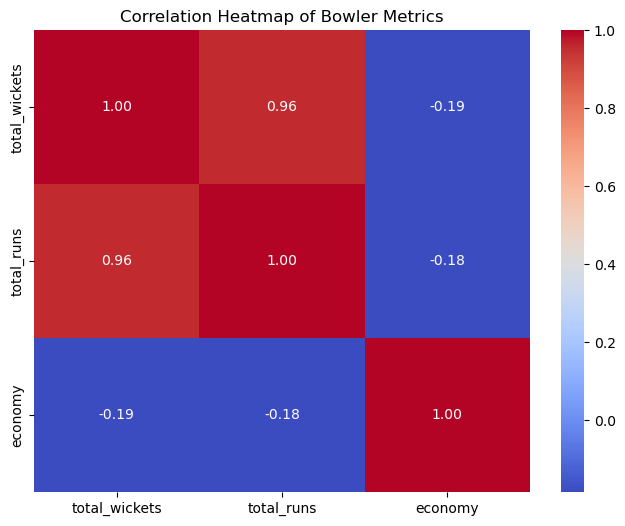

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = bowling_stats[['total_wickets', 'total_runs', 'economy']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Bowler Metrics')
plt.show()


In [36]:
# Grouping by teamInnings and summing the runs
team_runs = bating_summary.groupby('teamInnings')['runs'].sum().reset_index()

# Sorting the results by total runs in descending order
team_runs_sorted = team_runs.sort_values(by='runs', ascending=False)

# Displaying the total runs for each team
print(team_runs_sorted)


    teamInnings  runs
8   Super Kings  7372
5        Royals  7181
4           RCB  7028
2        Mumbai  6937
1           KKR  6870
3  Punjab Kings  6670
0      Capitals  6518
6     Sunrisers  6161
9        Titans  5423
7  Super Giants  4612


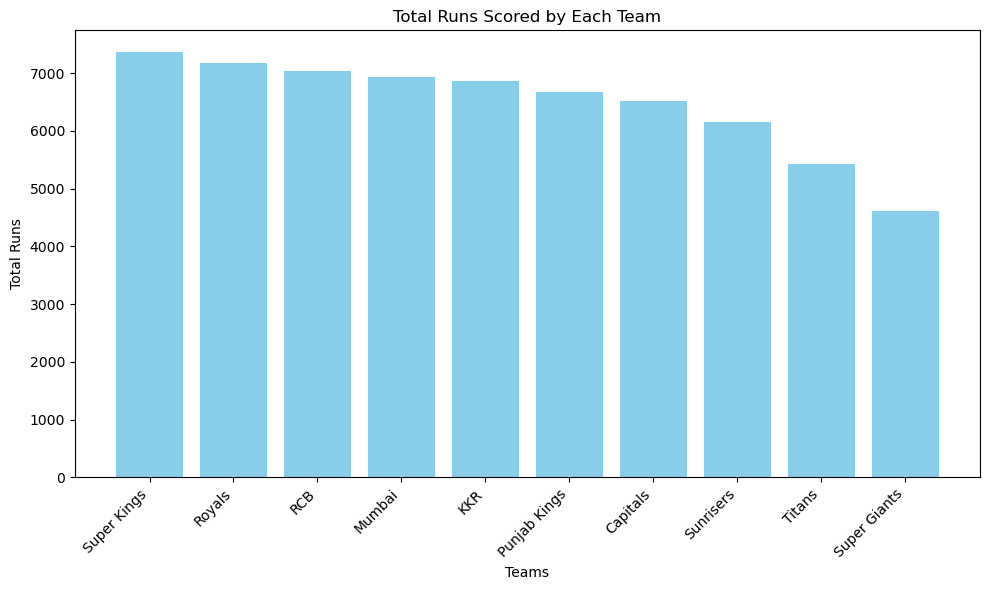

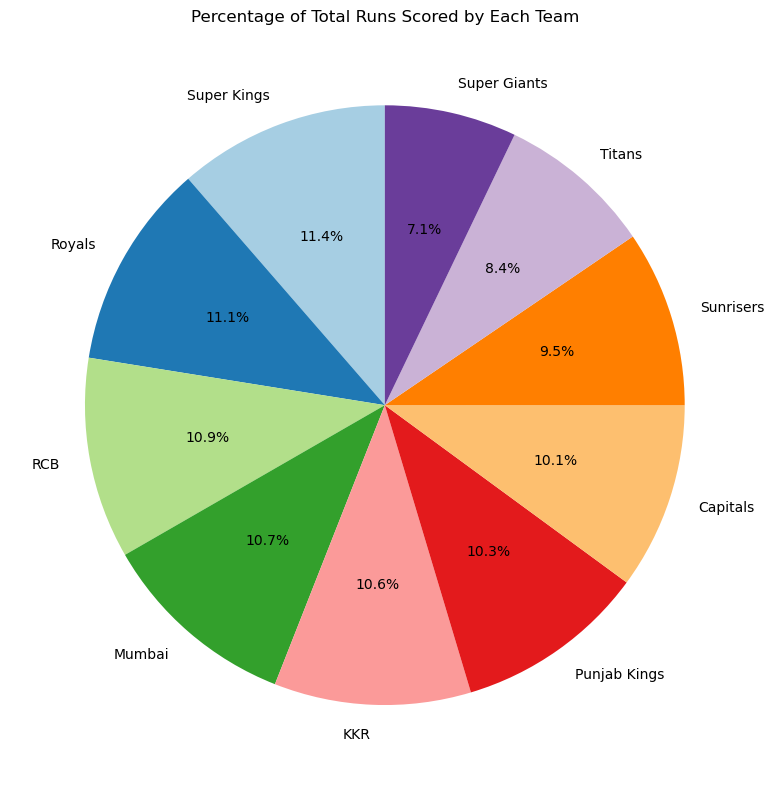

In [37]:
import matplotlib.pyplot as plt

# Generate the bar chart
plt.figure(figsize=(10, 6))
plt.bar(team_runs_sorted['teamInnings'], team_runs_sorted['runs'], color='skyblue')
plt.xlabel('Teams')
plt.ylabel('Total Runs')
plt.title('Total Runs Scored by Each Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the bar chart
plt.show()

# Generate the pie chart
plt.figure(figsize=(8, 8))
plt.pie(team_runs_sorted['runs'], labels=team_runs_sorted['teamInnings'], autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Percentage of Total Runs Scored by Each Team')
plt.tight_layout()

# Show the pie chart
plt.show()
